# QSVM Grid Search Results Analysis

**Professional visualization of Quantum Support Vector Machine grid search results.**

In [124]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects

# ===========================================
# PROFESSIONAL STYLE CONFIGURATION
# ===========================================

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Times New Roman'],
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'mathtext.fontset': 'cm',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'axes.linewidth': 1.2,
    'axes.edgecolor': '#333333',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

# Custom gradient colormaps
GRADIENT_TEAL = LinearSegmentedColormap.from_list('teal_gradient', 
    ['#E0F7FA', '#00ACC1', '#006064'], N=256)
GRADIENT_PURPLE = LinearSegmentedColormap.from_list('purple_gradient', 
    ['#F3E5F5', '#9C27B0', '#4A148C'], N=256)
GRADIENT_ORANGE = LinearSegmentedColormap.from_list('orange_gradient', 
    ['#FFF3E0', '#FF9800', '#E65100'], N=256)

# Color palette
COLORS = {
    'primary': '#1976D2',
    'danger': '#D32F2F',
    'dark': '#263238',
}

# Feature map name mapping
FM_MAP = {
    'feature_map_angle1': 'R1',
    'feature_map_qnn2': 'R2',
    'feature_map_angle3': 'R3',
}

def format_label(pca_dim, feature_map):
    """Format config label as n=X_RY"""
    r_label = FM_MAP.get(feature_map, feature_map)
    return f"n={int(pca_dim)}_{r_label}"

print("Style loaded.")

Style loaded.


In [125]:
# ===========================================
# LOAD RESULTS
# ===========================================

RESULTS_FILE = "qsvm_grid_search_results_20251229_173347.pkl"  # <-- CHANGE THIS

with open(RESULTS_FILE, "rb") as f:
    results = pickle.load(f)

# Create sorted dataframe (descending by test accuracy)
rows = []
for k, v in results.items():
    pca_dim = v.get('pca_dim', None)
    feature_map = v.get('feature_map', None)
    
    # Create short label
    if pca_dim is not None and feature_map is not None:
        short_label = format_label(pca_dim, feature_map)
    else:
        short_label = k
    
    # Compute avg encoding time from train_state_time (if available)
    # train_state_time is for 11315 training samples
    train_state_time = v.get('train_state_time', None)
    avg_encoding_time = v.get('avg_encoding_time', None)
    if avg_encoding_time is None and train_state_time is not None:
        avg_encoding_time = train_state_time / 11315  # Approximate
    
    rows.append({
        'config': k,
        'short_label': short_label,
        'pca_dim': pca_dim,
        'feature_map': feature_map,
        'test_accuracy': v['test_accuracy'],
        'val_accuracy': v.get('val_accuracy', None),
        'roc_auc': v['roc_auc'],
        'train_state_time': train_state_time,
        'train_kernel_time': v.get('train_kernel_time', None),
        'svm_train_time': v.get('svm_train_time', None),
        'avg_encoding_time': avg_encoding_time,
    })

df = pd.DataFrame(rows).sort_values('test_accuracy', ascending=False).reset_index(drop=True)

print(f"Loaded {len(df)} configurations from {RESULTS_FILE}")
display(df[['short_label', 'test_accuracy', 'roc_auc', 'pca_dim', 'feature_map', 'avg_encoding_time']])

Loaded 9 configurations from qsvm_grid_search_results_20251229_173347.pkl


,short_label,test_accuracy,roc_auc,pca_dim,feature_map,avg_encoding_time
0,n=4_R2,0.862839,0.888934,4,feature_map_qnn2,0.000479
1,n=5_R2,0.862839,0.888934,5,feature_map_qnn2,0.000534
2,n=4_R1,0.858314,0.885381,4,feature_map_angle1,0.000514
3,n=4_R3,0.858314,0.885381,4,feature_map_angle3,0.000568
4,n=5_R1,0.858314,0.885381,5,feature_map_angle1,0.000667
5,n=5_R3,0.858314,0.885381,5,feature_map_angle3,0.000719
6,n=3_R1,0.850113,0.871895,3,feature_map_angle1,0.000599
7,n=3_R3,0.850113,0.871895,3,feature_map_angle3,0.000485
8,n=3_R2,0.835407,0.868119,3,feature_map_qnn2,0.000470


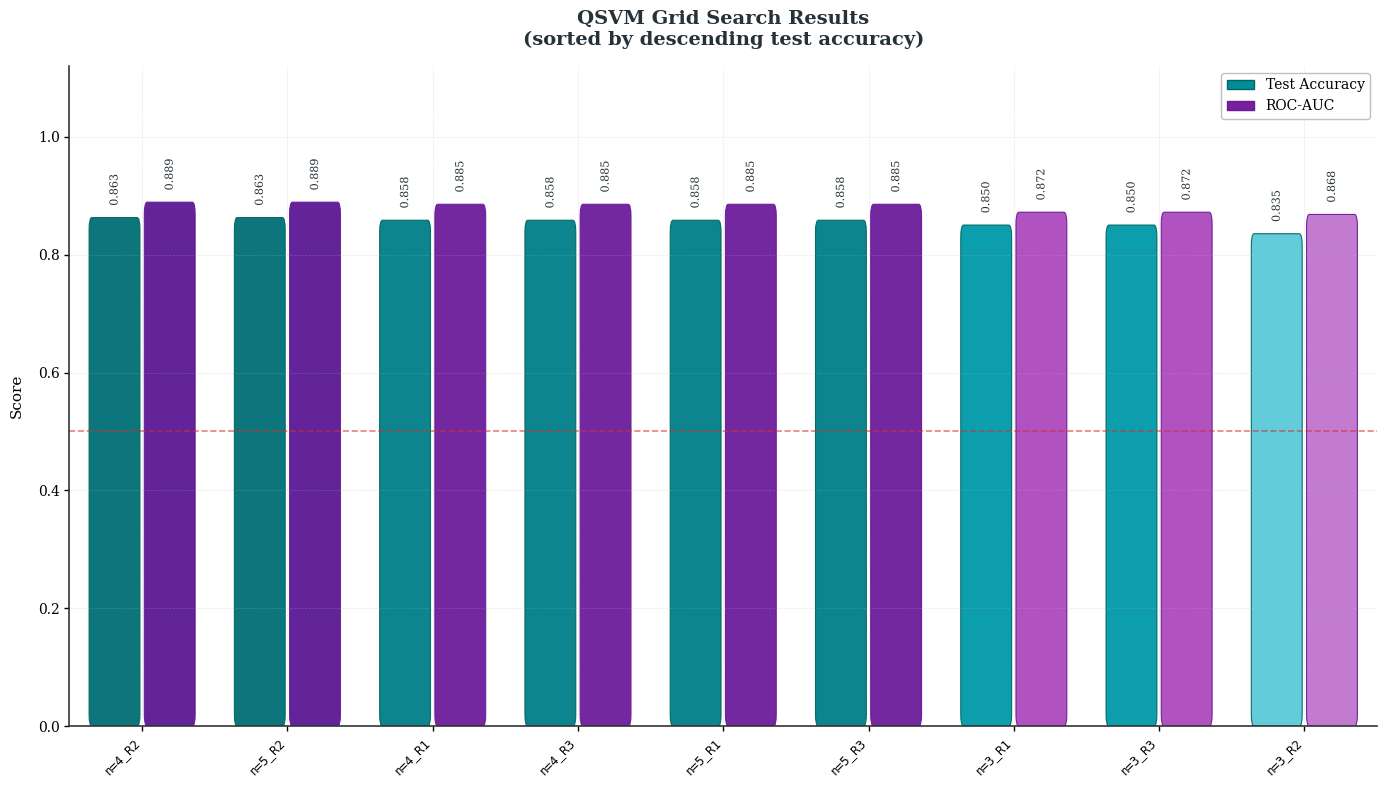

In [126]:
# ===========================================
# GROUPED VERTICAL BAR CHART
# 2 bars per config: Test Accuracy, ROC-AUC
# ===========================================

fig, ax = plt.subplots(figsize=(max(14, len(df) * 1.2), 8))
fig.patch.set_facecolor('white')

n = len(df)
x = np.arange(n)
bar_width = 0.35
gap = 0.03

# Draw grouped bars with FancyBboxPatch
metrics = [
    ('Test Accuracy', df['test_accuracy'].values, GRADIENT_TEAL, '#00695C', '.3f'),
    ('ROC-AUC', df['roc_auc'].values, GRADIENT_PURPLE, '#6A1B9A', '.3f'),
]

for m_idx, (label, values, cmap, edge_color, fmt) in enumerate(metrics):
    # Calculate bar positions (center the 2 bars)
    offset = (m_idx - 0.5) * (bar_width + gap)
    
    for i, (pos, val) in enumerate(zip(x, values)):
        if pd.isna(val):
            continue
        
        # Color based on value
        val_range = values.max() - values.min()
        norm_val = (val - values.min()) / val_range if val_range > 0 else 0.5
        color = cmap(0.3 + 0.6 * norm_val)
        
        # Draw vertical bar
        fancy_box = FancyBboxPatch(
            (pos + offset - bar_width/2, 0), bar_width, val,
            boxstyle="round,rounding_size=0.02,pad=0",
            facecolor=color,
            edgecolor=edge_color,
            linewidth=0.8,
            alpha=0.95
        )
        ax.add_patch(fancy_box)
        
        # Value label on top
        label_text = ax.text(pos + offset, val + 0.02, f'{val:{fmt}}',
                             ha='center', va='bottom', fontsize=8, fontweight='medium',
                             color=COLORS['dark'], rotation=90)
        label_text.set_path_effects([path_effects.withStroke(linewidth=1.5, foreground='white')])

# Create legend patches
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(facecolor=GRADIENT_TEAL(0.7), edgecolor='#00695C', label='Test Accuracy'),
    mpatches.Patch(facecolor=GRADIENT_PURPLE(0.7), edgecolor='#6A1B9A', label='ROC-AUC'),
]

# Styling
ax.set_xticks(x)
ax.set_xticklabels(df['short_label'].values, rotation=45, ha='right', fontsize=9, fontfamily='monospace')
ax.set_ylabel('Score', fontsize=11, fontweight='medium', labelpad=10)
ax.set_title('QSVM Grid Search Results\n(sorted by descending test accuracy)', 
             fontsize=14, fontweight='bold', color=COLORS['dark'], pad=15)

ax.set_xlim(-0.5, n - 0.5)
ax.set_ylim(0, 1.12)

# Random baseline
ax.axhline(y=0.5, color=COLORS['danger'], linestyle='--', linewidth=1.2, alpha=0.6, label='Random (0.5)')

# Legend
ax.legend(handles=legend_handles, loc='upper right', frameon=True, 
          facecolor='white', edgecolor='#BDBDBD', framealpha=0.95)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig('qsvm_results_grouped.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

In [127]:
# ===========================================
# SUMMARY STATISTICS
# ===========================================

print("=" * 60)
print("QSVM GRID SEARCH SUMMARY")
print("=" * 60)

print(f"\nTotal configurations tested: {len(df)}")

# Best and worst
best = df.iloc[0]
worst = df.iloc[-1]

print(f"\nBest configuration:")
print(f"  Config: {best['short_label']}")
print(f"  Test Accuracy: {best['test_accuracy']:.4f}")
print(f"  ROC-AUC: {best['roc_auc']:.4f}")

print(f"\nWorst configuration:")
print(f"  Config: {worst['short_label']}")
print(f"  Test Accuracy: {worst['test_accuracy']:.4f}")
print(f"  ROC-AUC: {worst['roc_auc']:.4f}")

# Statistics
print(f"\nStatistics:")
print(f"  Test Accuracy - Mean: {df['test_accuracy'].mean():.4f}, Std: {df['test_accuracy'].std():.4f}")
print(f"  ROC-AUC - Mean: {df['roc_auc'].mean():.4f}, Std: {df['roc_auc'].std():.4f}")

# Performance by feature map
print(f"\nPerformance by Feature Map:")
for fm in df['feature_map'].unique():
    subset = df[df['feature_map'] == fm]
    r_label = FM_MAP.get(fm, fm)
    print(f"  {r_label} ({fm}):")
    print(f"    Avg Test Accuracy: {subset['test_accuracy'].mean():.4f}")
    print(f"    Avg ROC-AUC: {subset['roc_auc'].mean():.4f}")

# Performance by PCA dimension
print(f"\nPerformance by PCA Dimension:")
for pca in sorted(df['pca_dim'].unique()):
    subset = df[df['pca_dim'] == pca]
    print(f"  n={int(pca)}:")
    print(f"    Avg Test Accuracy: {subset['test_accuracy'].mean():.4f}")
    print(f"    Avg ROC-AUC: {subset['roc_auc'].mean():.4f}")

QSVM GRID SEARCH SUMMARY

Total configurations tested: 9

Best configuration:
  Config: n=4_R2
  Test Accuracy: 0.8628
  ROC-AUC: 0.8889

Worst configuration:
  Config: n=3_R2
  Test Accuracy: 0.8354
  ROC-AUC: 0.8681

Statistics:
  Test Accuracy - Mean: 0.8550, Std: 0.0086
  ROC-AUC - Mean: 0.8813, Std: 0.0082

Performance by Feature Map:
  R2 (feature_map_qnn2):
    Avg Test Accuracy: 0.8537
    Avg ROC-AUC: 0.8820
  R1 (feature_map_angle1):
    Avg Test Accuracy: 0.8556
    Avg ROC-AUC: 0.8809
  R3 (feature_map_angle3):
    Avg Test Accuracy: 0.8556
    Avg ROC-AUC: 0.8809

Performance by PCA Dimension:
  n=3:
    Avg Test Accuracy: 0.8452
    Avg ROC-AUC: 0.8706
  n=4:
    Avg Test Accuracy: 0.8598
    Avg ROC-AUC: 0.8866
  n=5:
    Avg Test Accuracy: 0.8598
    Avg ROC-AUC: 0.8866


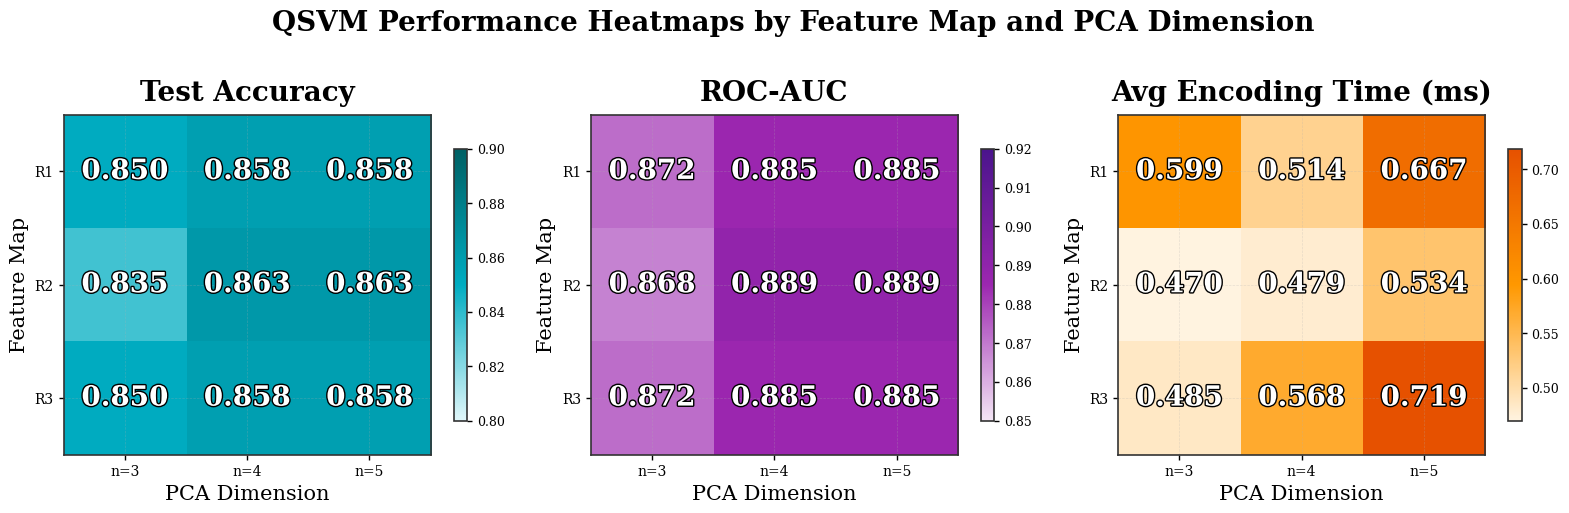

In [135]:
# ===========================================
# HEATMAPS: 3x1 LAYOUT
# Test Accuracy, ROC-AUC, Avg Encoding Time
# ===========================================

# Create short feature map names for plotting
df['fm_short'] = df['feature_map'].map(FM_MAP)

# Pivot tables for heatmaps
pivot_acc = df.pivot_table(values='test_accuracy', index='fm_short', columns='pca_dim', aggfunc='mean')
pivot_roc = df.pivot_table(values='roc_auc', index='fm_short', columns='pca_dim', aggfunc='mean')
pivot_time = df.pivot_table(values='avg_encoding_time', index='fm_short', columns='pca_dim', aggfunc='mean')

# Convert time to milliseconds for better readability
pivot_time_ms = pivot_time * 1000

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.patch.set_facecolor('white')

# Test Accuracy heatmap
im0 = axes[0].imshow(pivot_acc.values, cmap=GRADIENT_TEAL, aspect='auto', vmin=0.8, vmax=0.9)
axes[0].set_title('Test Accuracy', fontsize=20, fontweight='bold', pad=10)
axes[0].set_xlabel('PCA Dimension', fontsize=15)
axes[0].set_ylabel('Feature Map', fontsize=15)
axes[0].set_xticks(range(len(pivot_acc.columns)))
axes[0].set_yticks(range(len(pivot_acc.index)))
axes[0].set_xticklabels([f'n={int(c)}' for c in pivot_acc.columns])
axes[0].set_yticklabels(pivot_acc.index)

# Annotate cells
for i in range(len(pivot_acc.index)):
    for j in range(len(pivot_acc.columns)):
        val = pivot_acc.values[i, j]
        text = axes[0].text(j, i, f'{val:.3f}', ha='center', va='center', 
                           fontsize=20, fontweight='bold', color='white')
        text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='black')])

cbar0 = fig.colorbar(im0, ax=axes[0], shrink=0.8)
cbar0.ax.tick_params(labelsize=9)

# ROC-AUC heatmap
im1 = axes[1].imshow(pivot_roc.values, cmap=GRADIENT_PURPLE, aspect='auto', vmin=0.85, vmax=0.92)
axes[1].set_title('ROC-AUC', fontsize=20, fontweight='bold', pad=10)
axes[1].set_xlabel('PCA Dimension', fontsize=15)
axes[1].set_ylabel('Feature Map', fontsize=15)
axes[1].set_xticks(range(len(pivot_roc.columns)))
axes[1].set_yticks(range(len(pivot_roc.index)))
axes[1].set_xticklabels([f'n={int(c)}' for c in pivot_roc.columns])
axes[1].set_yticklabels(pivot_roc.index)

# Annotate cells
for i in range(len(pivot_roc.index)):
    for j in range(len(pivot_roc.columns)):
        val = pivot_roc.values[i, j]
        text = axes[1].text(j, i, f'{val:.3f}', ha='center', va='center', 
                           fontsize=20, fontweight='bold', color='white')
        text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='black')])

cbar1 = fig.colorbar(im1, ax=axes[1], shrink=0.8)
cbar1.ax.tick_params(labelsize=9)

# Avg Encoding Time heatmap
im2 = axes[2].imshow(pivot_time_ms.values, cmap=GRADIENT_ORANGE, aspect='auto')
axes[2].set_title('Avg Encoding Time (ms)', fontsize=20, fontweight='bold', pad=10)
axes[2].set_xlabel('PCA Dimension', fontsize=15)
axes[2].set_ylabel('Feature Map', fontsize=15)
axes[2].set_xticks(range(len(pivot_time_ms.columns)))
axes[2].set_yticks(range(len(pivot_time_ms.index)))
axes[2].set_xticklabels([f'n={int(c)}' for c in pivot_time_ms.columns])
axes[2].set_yticklabels(pivot_time_ms.index)

# Annotate cells
for i in range(len(pivot_time_ms.index)):
    for j in range(len(pivot_time_ms.columns)):
        val = pivot_time_ms.values[i, j]
        text = axes[2].text(j, i, f'{val:.3f}', ha='center', va='center', 
                           fontsize=20, fontweight='bold', color='white')
        text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='black')])

cbar2 = fig.colorbar(im2, ax=axes[2], shrink=0.8)
cbar2.ax.tick_params(labelsize=9)

plt.suptitle('QSVM Performance Heatmaps by Feature Map and PCA Dimension', 
             fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('qsvm_heatmaps.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

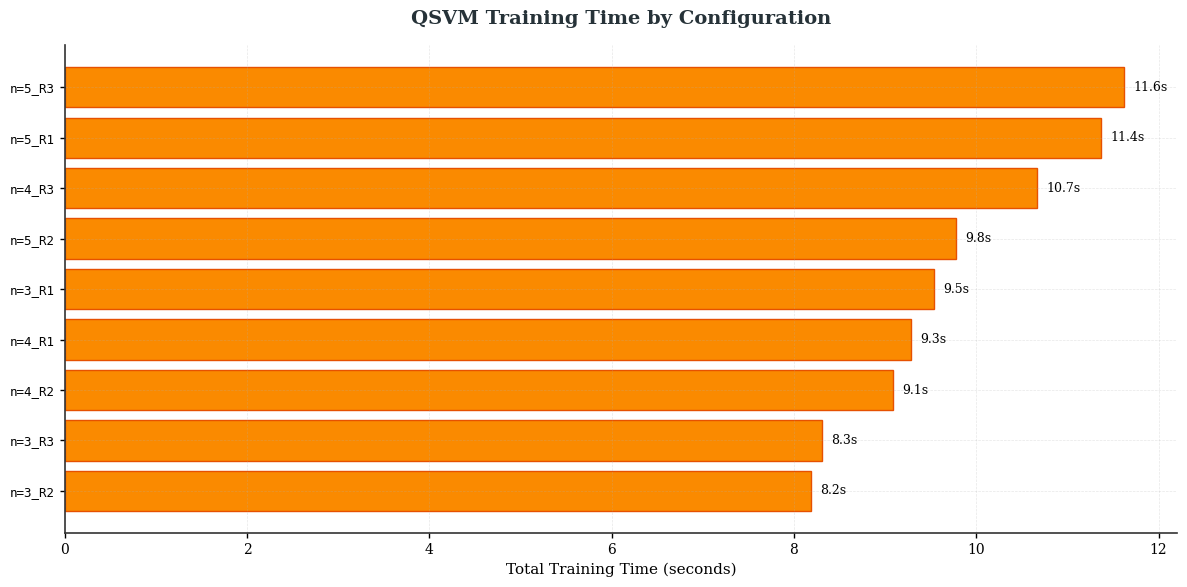


Timing Summary:
  Average total time: 9.76s
  Fastest: n=3_R2 (8.19s)
  Slowest: n=5_R3 (11.62s)

Avg Encoding Time per Sample:
  Mean: 0.5595 ms
  Min: 0.4701 ms (n=3_R2)
  Max: 0.7185 ms (n=5_R3)


In [129]:
# ===========================================
# TIMING ANALYSIS
# ===========================================

if df['train_state_time'].notna().any():
    # Calculate total time per config
    df['total_time'] = df['train_state_time'].fillna(0) + df['train_kernel_time'].fillna(0) + df['svm_train_time'].fillna(0)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('white')
    
    # Sort by total time for this plot
    df_time = df.sort_values('total_time', ascending=True)
    
    bars = ax.barh(range(len(df_time)), df_time['total_time'], color=GRADIENT_ORANGE(0.6), edgecolor='#E65100')
    
    ax.set_yticks(range(len(df_time)))
    ax.set_yticklabels(df_time['short_label'], fontsize=9, fontfamily='monospace')
    ax.set_xlabel('Total Training Time (seconds)', fontsize=11, fontweight='medium')
    ax.set_title('QSVM Training Time by Configuration', fontsize=14, fontweight='bold', color=COLORS['dark'], pad=15)
    
    # Add time labels
    for i, (idx, row) in enumerate(df_time.iterrows()):
        ax.text(row['total_time'] + 0.1, i, f'{row["total_time"]:.1f}s', va='center', fontsize=9)
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('qsvm_timing.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()
    
    print(f"\nTiming Summary:")
    print(f"  Average total time: {df['total_time'].mean():.2f}s")
    print(f"  Fastest: {df_time.iloc[0]['short_label']} ({df_time.iloc[0]['total_time']:.2f}s)")
    print(f"  Slowest: {df_time.iloc[-1]['short_label']} ({df_time.iloc[-1]['total_time']:.2f}s)")
    
    # Avg encoding time summary
    if df['avg_encoding_time'].notna().any():
        print(f"\nAvg Encoding Time per Sample:")
        print(f"  Mean: {df['avg_encoding_time'].mean()*1000:.4f} ms")
        print(f"  Min: {df['avg_encoding_time'].min()*1000:.4f} ms ({df.loc[df['avg_encoding_time'].idxmin(), 'short_label']})")
        print(f"  Max: {df['avg_encoding_time'].max()*1000:.4f} ms ({df.loc[df['avg_encoding_time'].idxmax(), 'short_label']})")
else:
    print("No timing data available.")